# Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pylab
%matplotlib inline

# Functions

In [2]:
def rbe_wedenberg(dose, let, abx,q):
    """
    Wedenberg proton RBE model
    input parameters may be either numpy.array or scalars
    TODO: handle Cube() class directly
    :params dose: physical proton dose in [Gy]
    :params let: LETd in [keV/um] (protons only)
    :params abx: alpha_x / beta_x [Gy]
    :returns: RBE for the given parameters
    :ref: http://dx.doi.org/10.3109/0284186X.2012.705892
    """

    _apx = 1.000 + q * let / abx
    _sbpx = 1.0

    rbe = _rbe_apx(dose, _apx, _sbpx, abx)
    return rbe

In [3]:
def _rbe_apx(dose, apx, sbpx, abx, dzero=0.0):
    """
    :params dose: proton dose      [Gy]
    :params apx: alpha_p / alpha_x [dimensionless] RBE_max = ap/ax when (dose -> 0 Gy)
    :params sbpx: beta_p / beta_x  [dimensionless] RBE_min = sqrt(bp/bx) when (dose -> inf Gy)
    :params abx: alpha_x / beta_x  [Gy]
    :params dzero: what to return in case of dose is zero (which would cause division by zero)
    """

    _rbe = 1.0 / (2.0 * dose)
    if hasattr(_rbe, '__iter__'):
        _rbe[_rbe == np.inf] = dzero
    else:
        if _rbe == np.inf:
            return dzero
    delta = abx * abx + 4. * abx * apx * dose + 4. * sbpx * sbpx * dose * dose
    delta *= (delta > 0)
    _rbe *= (np.sqrt(delta) - abx)
    return _rbe

In [4]:
def plot_style():
    plt.grid()
    plt.minorticks_on()
    plt.grid(which='major', linestyle=':', linewidth='0.2', color='k')
    plt.grid(which='minor', linestyle=':', linewidth='0.2', color='k')

    plt.rcParams['xtick.direction'] = 'in' 
    plt.rcParams['ytick.direction'] = 'in' 
    plt.rcParams['xtick.top'] = True 
    plt.rcParams['ytick.right'] = True  
    plt.rc('font', size='20')  
    
    params = {'legend.fontsize': '20',
         'figure.figsize': (10,6),
         'axes.labelsize': '26',
         'axes.titlesize':'26',
         'xtick.labelsize':'20',
         'ytick.labelsize':'20',
         'xtick.major.pad':'16',
         'ytick.major.pad':'16'}
    
    pylab.rcParams.update(params)

# Open data

In [5]:
fname = os.path.join('tmp','distrib_q.h5')
q = pd.read_hdf(fname, 'q',columns=['q'])

In [6]:
fname = os.path.join('data',"sobp_10mln")
dose = os.path.join(fname,'dose.dat')
let=os.path.join(fname,'dlet.dat')

In [7]:
dozym = os.path.join('data','doz_sobp.xlsx')
df_dozym = pd.read_excel(dozym,names=['depth','dose','depth2','dose2'])

In [8]:
df_dose=pd.read_table(dose,names=['z','dose','err'],sep='\s+')
df_let=pd.read_table(let,names=['z','let','err'],sep='\s+')

In [9]:
# LET and normalized dose in water phantom
dose_max=df_dose.dose[df_dose.dose>0.95*df_dose.dose.max()].mean()
rbe= pd.DataFrame(dtype='float')

rbe["dose"]=df_dose['dose']*2/dose_max
rbe["let"]=df_let['let']
rbe["z"]=df_dose['z']

# Wedenberg RBE distribution for LET=2.

In [10]:
tmp = rbe_wedenberg(2.0,3.0, 2.0, q )

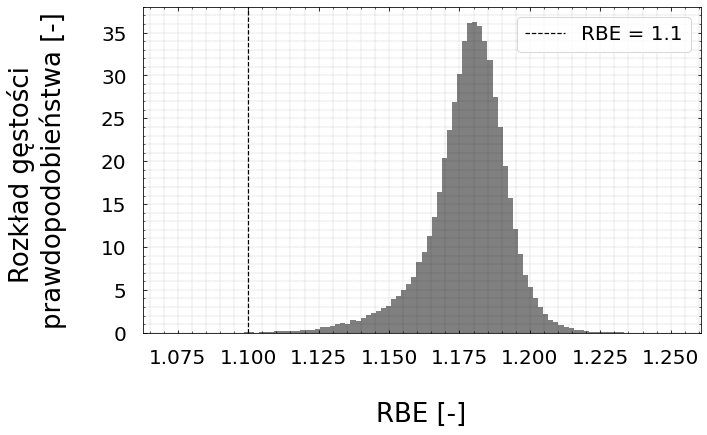

In [32]:
tmp.hist(bins=(100), density=True,color='grey')
plt.axvline(x=1.1, label='RBE = 1.1'.format(1.1),c='k',ls='--',lw=1.2)

plot_style()
plt.title("")
plt.xlabel("\nRBE [-]")
plt.ylabel("Rozkład gęstości \nprawdopodobieństwa [-]\n")
plt.legend()

tmp=pd.DataFrame(list(zip(tmp)),
                          columns=['rbe'])
tmp.to_csv("results/figure_5_9")

plt.savefig(fname="results/figure_5_9",dpi= 700)

In [12]:
#RBE for q=0.434 from Wedenberg
abx=2.
rbe['wed'] = rbe_wedenberg(rbe.dose, rbe.let, abx, 0.434)
rbe['wed_q_down'] = rbe_wedenberg(rbe.dose, rbe.let, abx, 0.366)
rbe['wed_q_up'] = rbe_wedenberg(rbe.dose, rbe.let, abx, 0.513)

# our RBE distribution

In [13]:
dfr = (rbe.reset_index(inplace=False))

In [14]:
#optional : n=q.size-1
n=1000-1

In [15]:
dfr =dfr.append([dfr]*n)

In [16]:
dfr=(dfr.reset_index(inplace=False))[['z','let', 'dose']]

In [17]:
dfr=dfr.sort_values(by=['z', 'let','dose'])

In [18]:
dfr.set_index(['z'],inplace=True) 

In [19]:
for name, group in dfr.groupby('z'):

    dfr.loc[(name), "q"] = q.q.values[:n+1]


In [20]:
for name, group in dfr.groupby('z'):
    DOSE=group.dose.values
    LET=group.let.values
    Q=group.q.values  
    dfr.loc[(name), "rbe"] = rbe_wedenberg(DOSE, LET, abx, Q)


In [21]:
dfr.reset_index(inplace=True)

In [22]:
dfr_tmp= pd.DataFrame()
dfr_tmp["mediana"]=dfr.groupby('z').rbe.median()
dfr_tmp["meana"]=dfr.groupby('z').rbe.mean()
dfr_tmp["q_down"]=dfr.groupby('z').rbe.quantile(0.075)
dfr_tmp["q_up"]=dfr.groupby('z').rbe.quantile(0.925)

# Biological Dose in SOBP

In [23]:
limit=df_dose.z[df_dose.dose<=df_dose.dose.max()*0.01].iloc[0]

In [24]:
figure2_df= pd.DataFrame()

In [25]:
figure2_df["Distance_cm"] = rbe.z
figure2_df["Ext_Model_median"] = dfr.groupby('z').rbe.median().values*rbe.dose
figure2_df["Ext_Model_mean"] = dfr.groupby('z').rbe.mean().values*rbe.dose

figure2_df["Wedenberg"] = rbe.wed*rbe.dose
figure2_df["Wedenberg_quantile_down"] = rbe.wed_q_down*rbe.dose
figure2_df["Wedenberg_quantile_up"] = rbe.wed_q_up*rbe.dose

figure2_df["Physical__Dose"] = rbe.dose
figure2_df["Dose_for_RBE_1_1"] = rbe.dose*1.1
figure2_df["Ext_Model_quantile_down"] = dfr.groupby('z').rbe.quantile(0.075).values*rbe.dose
figure2_df["Ext_Model_quantile_up"] = dfr.groupby('z').rbe.quantile(0.925).values*rbe.dose

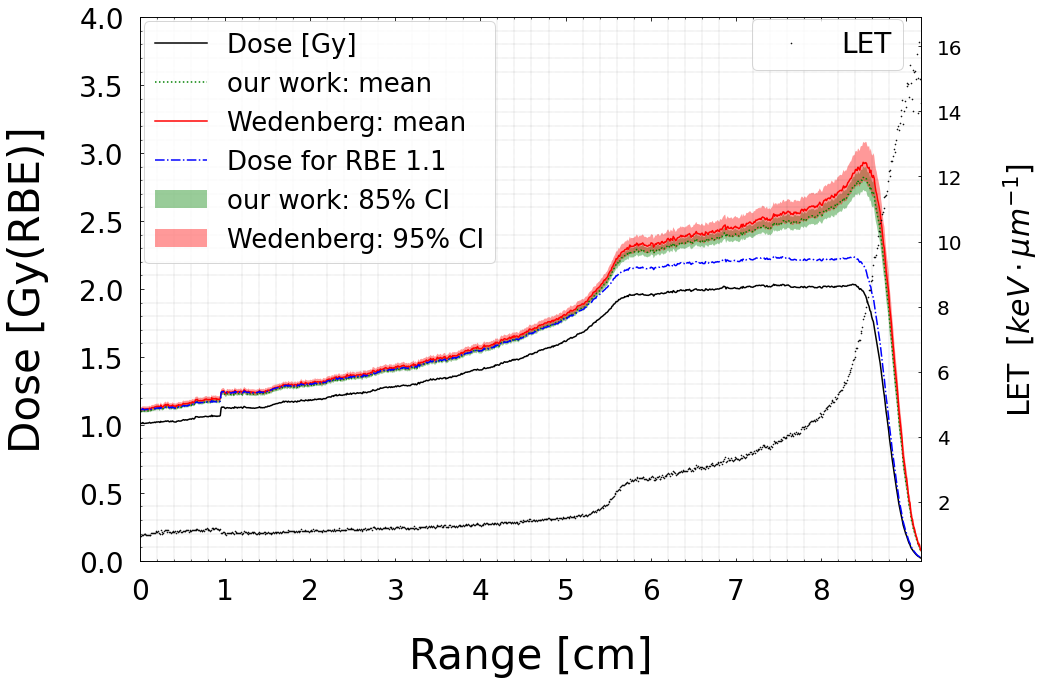

In [58]:
fig,ax = plt.subplots(figsize=[14, 10])
matplotlib.rcParams.update({'font.size': 36})

ax2=ax.twinx()
ax.set_xlabel("Range [cm]",size=42, labelpad = 30)
ax.set_ylabel("Dose [Gy(RBE)]",size=42, labelpad = 30)
ax2.set_ylabel("\nLET "+r"$\;[keV \cdot \mu m^{-1}]$",size=30,rotation=90)

ax.set_xlim(0,limit)
ax.set_ylim(0,4)
ax.set_xticks(np.arange(0, 10, 1.0))

ax2.plot(rbe.z, rbe.let,'k.',markersize=1.2, label = "LET")

ax.plot(rbe.z, rbe.dose,c='k',label="Dose [Gy]")
ax.plot(figure2_df.Distance_cm,figure2_df.Ext_Model_mean,'g:',markersize=0.2, label= "our work: mean")
ax.plot(figure2_df.Distance_cm,figure2_df.Wedenberg,'r', label = "Wedenberg: mean")
ax.plot(figure2_df.Distance_cm, figure2_df.Dose_for_RBE_1_1,'b-.',markersize=0.1, label = "Dose for RBE 1.1") 

y1=figure2_df.Ext_Model_quantile_down
y2=figure2_df.Ext_Model_quantile_up
y3=figure2_df.Wedenberg_quantile_down
y4=figure2_df.Wedenberg_quantile_up

ax.fill_between(rbe.z,y1,y2, where=y2 >y1, facecolor='g', alpha=0.4, label = "our work: 85% CI")
ax.fill_between(rbe.z,y3,y4, where=y4 >y3, facecolor='r', alpha=0.4, label = "Wedenberg: 95% CI")

ax.grid()
ax.minorticks_on()
ax.grid(which='both', linestyle=':', linewidth='0.2', color='black')
ax.tick_params(axis='both', which='major', labelsize=28)
#plt.rcParams['xtick.direction'] = 'in' 
#plt.rcParams['ytick.direction'] = 'in' 
#plt.rcParams['xtick.top'] = True 
#plt.rcParams['ytick.right'] = True


ax.legend(loc="center",bbox_to_anchor=(0.23, 0.77), borderaxespad=0.,fontsize=26)
ax2.legend(loc="center",bbox_to_anchor=(0.88, 0.95), borderaxespad=0.,fontsize=28)

# IN SOBP

In [45]:
def dose_in_sobp(range_insobp):
    df_ = rbe_wedenberg(np.float64(rbe[rbe.z==range_insobp].dose.values), 
                        rbe[rbe.z == range_insobp].let.values, 
                        abx, q.q)*rbe[rbe.z == range_insobp].dose.values
    
    df_.hist(bins = 400, color='green',label = "praca Jeleń: rozkład",density=True)
    
    plt.axvline(figure2_df[figure2_df.Distance_cm == range_insobp].Ext_Model_median.values, 
                c='black',label='praca Jeleń: mediana')
    plt.axvspan(figure2_df[figure2_df.Distance_cm == range_insobp].Wedenberg_quantile_down.values, 
                figure2_df[figure2_df.Distance_cm == range_insobp].Wedenberg_quantile_up.values, 
                alpha=0.4, color='red',label="praca Wedenberg: 95% Przedział Ufności")
    
    plt.axvspan(figure2_df[figure2_df.Distance_cm == range_insobp].Ext_Model_quantile_down.values, 
                figure2_df[figure2_df.Distance_cm == range_insobp].Ext_Model_quantile_up.values, 
                alpha=0.4, color='green',label="praca Jeleń 85% Przedział Ufności")
    plt.axvline(figure2_df[figure2_df.Distance_cm == range_insobp].Dose_for_RBE_1_1.values, 
                c='blue',label='dawka dla RBE=1.1')
    plt.axvline(figure2_df[figure2_df.Distance_cm == range_insobp].Wedenberg.values, 
                c='red',label='praca Wedenberg: dla q=0.434')

    plot_style()
    plt.xlabel("\nDawka Biologiczna [Gy(RBE)]")
    plt.ylabel("Rozkład gęstości \nprawdopodobieństwa [-]\n")
    
    #plt.title("Rozkład dawki biologicznej na głębokości "+ str(range_insobp)+"cm")
    
    #plt.legend(title = "Rozkład dawki biologicznej na głębokości "+ str(range_insobp)+"cm",bbox_to_anchor=(0.7, 1), loc='lower center')

C:\Users\Kinga Jelen\Anaconda\envs\pytrip\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\Kinga Jelen\Anaconda\envs\pytrip\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


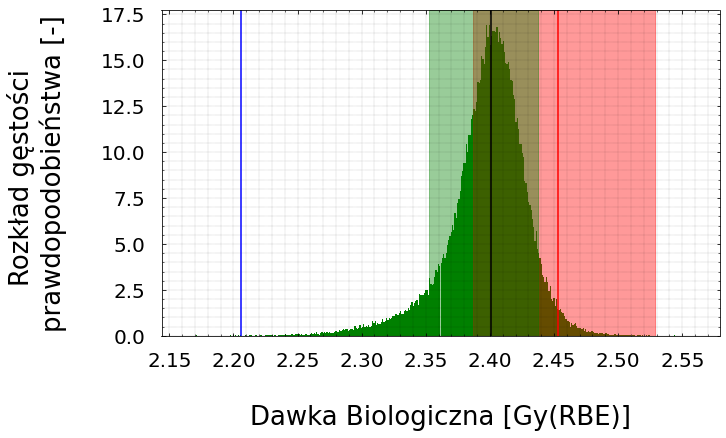

In [46]:
dose_in_sobp(7.015)

C:\Users\Kinga Jelen\Anaconda\envs\pytrip\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\Kinga Jelen\Anaconda\envs\pytrip\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


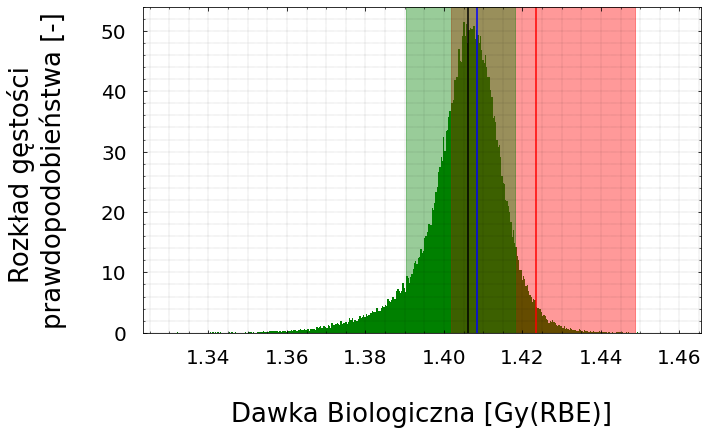

In [47]:
dose_in_sobp(3.015)

C:\Users\Kinga Jelen\Anaconda\envs\pytrip\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\Kinga Jelen\Anaconda\envs\pytrip\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


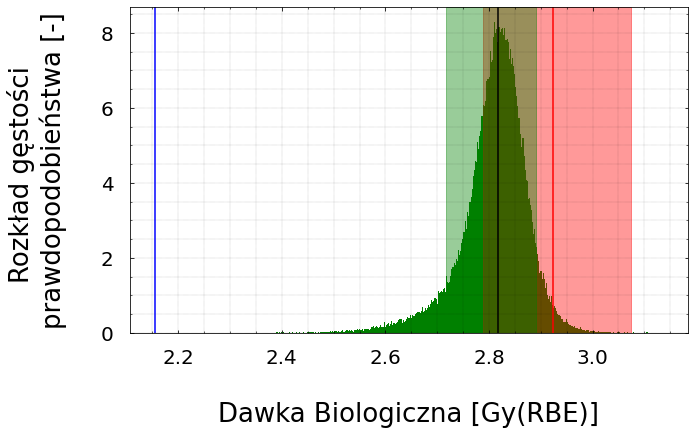

In [48]:
dose_in_sobp(8.515)